# Project 3 — Cepheid Period–Luminosity Analysis (OGLE / LMC vs SMC)

## Authors: Abdirahman Abdullahi, Kyle Drees  
## Course: Astronomy 1221  
## GitHub Repo: *https://github.com/MUTEJIMMY/Astron1221_Project3_Cepheids_Abdirahman_Kyle*

In this project, we analyze the **Cepheid period–luminosity (P–L / Leavitt Law) relation** using OGLE survey data from the **Large Magellanic Cloud (LMC)** and **Small Magellanic Cloud (SMC)**. Cepheids are pulsating variable stars whose period is strongly correlated with intrinsic brightness, making them one of astronomy’s most important standard candles.

We build an end-to-end data analysis pipeline:

- Load and clean OGLE Cepheid catalogs for the LMC and SMC into consistent tables  
- Compute derived columns such as **log10(period)** and select photometric bands (e.g., I-band magnitude)  
- Fit the P–L relation using a linear model in log space: **m = a · log10(P) + b**  
- Estimate parameter uncertainties from the fit covariance and validate fits with residual plots and **χ² / reduced χ²**  
- Compare how the fitted relations differ between **LMC vs SMC** and across different **Cepheid types**  
- Present the results through a **Streamlit** app for exploring the fits and plots

# Project pathway and scientific context
Cepheids are a core rung of the **cosmic distance ladder**: once calibrated, they enable distances to nearby galaxies, which then help calibrate Type Ia supernovae and support measurements of the **Hubble constant**. Because modern measurements still show a disagreement (“Hubble tension”), careful Cepheid calibration and systematics remain important in cosmology.

# Physical interpretation focus
A major goal is not only fitting lines, but explaining what they mean:

- The P–L slope encodes how brightness changes with period for a Cepheid population  
- Differences between LMC and SMC fits can arise because the galaxies have different stellar environments (especially metallicity), which can shift Cepheid luminosities and P–L calibration

# Data sources
- OGLE Cepheid catalogs for the LMC and SMC (survey photometry and classifications)

# Run instructions
Run the notebook from top to bottom to reproduce the cleaned datasets, fitted P–L relations, goodness-of-fit statistics, and final visualizations (and the Streamlit app outputs if included).

# Background: The Cosmic Distance Ladder
Cepheids provide a fundamental rung on the cosmic distance ladder—once their Period–Luminosity (P–L) relation is calibrated, they enable distances to nearby galaxies, which then calibrate Type Ia supernovae used to measure the Hubble constant.  
Understanding how this relation depends on environment (e.g., metallicity) is critical to refining the cosmic distance scale and resolving the “Hubble tension.”

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
plt.style.use("seaborn-v0_8-darkgrid")
import os

# Data Preparation
We load OGLE Cepheid catalogs (LMC and SMC) and convert key columns to numeric form.
The main parameters are:
- `Per`: period (days)
- `Vmag` / `Imag`: apparent magnitudes
- `Type`: Cepheid classification

## Methods (what the code is doing)

We model the Cepheid Period–Luminosity relation in log-space as:

m = a · log10(P) + b

where P is the period (days), m is the observed magnitude in a chosen band (V or I), and (a, b) are fit parameters.

We fit (a, b) using scipy.optimize.curve_fit (least-squares). Parameter uncertainties come from the covariance matrix returned by the fit:

σ(a), σ(b) = sqrt(diag(pcov))

We evaluate fit quality using residuals and reduced χ² (using the RMS scatter of residuals as an empirical uncertainty when per-star measurement errors are not provided).

In [84]:
# ------------------------------------------------------------
# Load OGLE Cepheid catalog (LMC)
# ------------------------------------------------------------
# File should be in the same folder as this notebook
data_path = Path("asu.tsv")

# Read the tab-separated table; OGLE tables often include comment lines starting with '#'
df = pd.read_csv(data_path, sep="\t", comment="#")

# ------------------------------------------------------------
# Clean / type-convert key columns we will use
# ------------------------------------------------------------
# Convert selected columns to numeric (invalid parses become NaN)
num_cols = ["Per", "Vmag", "Imag", "E(B-V)"]
for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Keep only rows with ALL required fields present
# (Per = period, Vmag/Imag = observed magnitudes, Type = Cepheid subtype label)
clean = df[["Per", "Vmag", "Imag", "Type"]].dropna(subset=["Per", "Vmag", "Imag", "Type"]).copy()

# Small sanity check (helpful but not noisy)
print("LMC rows after cleaning:", len(clean))

LMC rows after cleaning: 204


In [85]:
# ------------------------------------------------------------
# Quick summary statistics after cleaning
# ------------------------------------------------------------
print("Summary statistics for cleaned LMC Cepheid table:")
display(clean.describe())

Summary statistics for cleaned LMC Cepheid table:


,Per,Vmag,Imag
count,204.000000,204.000000,204.000000
mean,4.478774,15.850598,15.128294
std,4.841457,0.827237,0.749328
min,0.403540,9.999000,13.056000
25%,2.354130,15.512750,14.761000
50%,3.375205,15.856000,15.122500
75%,4.896888,16.214750,15.416000
max,56.498190,18.870000,17.751000


In [86]:
# ------------------------------------------------------------
# Period–Luminosity model (log-space):
# V = a * log10(P) + b
# ------------------------------------------------------------
def pl_model(logP, a, b):
    """Linear P–L model in log-period space."""
    return a * logP + b

# Build the x and y arrays for the fit
logP = np.log10(clean["Per"].values)   # log10 of period in days
V = clean["Vmag"].values               # observed (apparent) V-band magnitude

# Fit the line using least-squares
popt, pcov = curve_fit(pl_model, logP, V)

# Unpack best-fit parameters
a, b = popt

# Parameter uncertainties from covariance matrix
a_err, b_err = np.sqrt(np.diag(pcov))

# Report results clearly
print("Best-fit P–L relation (LMC, apparent V):")
print(f"V = ({a:.3f} ± {a_err:.3f}) * log10(P) + ({b:.3f} ± {b_err:.3f})")

Best-fit P–L relation (LMC, apparent V):
V = (-1.816 ± 0.154) * log10(P) + (16.834 ± 0.095)


Estimated RMS scatter of residuals: 0.638 mag
Reduced chi^2 = 1.00


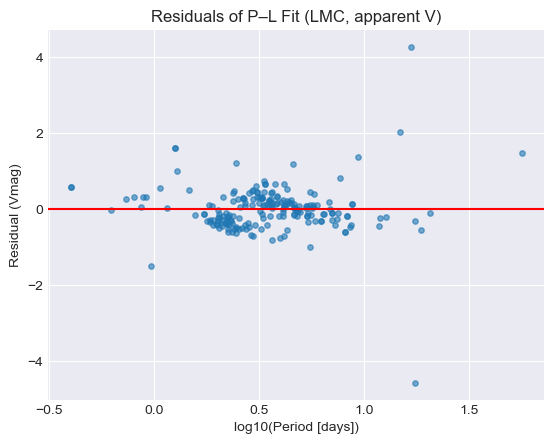

In [89]:
# ------------------------------------------------------------
# Reduced chi^2 using the actual scatter of the data
# (We estimate sigma from the RMS scatter of residuals)
# ------------------------------------------------------------

# 0) Recompute logP, V, and residuals from the *current* clean table
logP = np.log10(clean["Per"].values)
V = clean["Vmag"].values
resid = V - pl_model(logP, a, b)

# 1) Estimate typical uncertainty from the scatter of residuals
# ddof=2 because we fit 2 parameters (a and b)
sigma_est = np.std(resid, ddof=2)
print(f"Estimated RMS scatter of residuals: {sigma_est:.3f} mag")

# 2) Compute chi^2 and reduced chi^2
chi2 = np.sum((resid / sigma_est) ** 2)
dof = len(resid) - 2
chi2_red = chi2 / dof
print(f"Reduced chi^2 = {chi2_red:.2f}")

# 3) Residual plot (do NOT invert y-axis for residuals)
plt.figure()
plt.scatter(logP, resid, s=15, alpha=0.6)
plt.axhline(0, color="red")
plt.xlabel("log10(Period [days])")
plt.ylabel("Residual (Vmag)")
plt.title("Residuals of P–L Fit (LMC, apparent V)")
plt.grid(True)
plt.show()

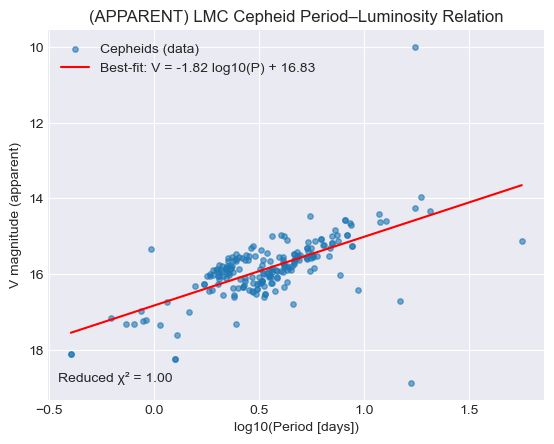

In [90]:
# ------------------------------------------------------------
# Plot the Period–Luminosity relation with best-fit line (LMC, apparent V)
# ------------------------------------------------------------
plt.figure()

# Data points
plt.scatter(logP, V, s=15, alpha=0.6, label="Cepheids (data)")

# Best-fit model line
x = np.linspace(logP.min(), logP.max(), 200)
plt.plot(x, pl_model(x, a, b), color="red",
         label=f"Best-fit: V = {a:.2f} log10(P) + {b:.2f}")

# In astronomy magnitude plots, we invert the y-axis so brighter is higher
plt.gca().invert_yaxis()

# Labels and title
plt.xlabel("log10(Period [days])")
plt.ylabel("V magnitude (apparent)")
plt.title("(APPARENT) LMC Cepheid Period–Luminosity Relation")

# If chi2_red exists from the previous cell, show it in the plot title area
try:
    plt.text(0.02, 0.05, f"Reduced χ² = {chi2_red:.2f}", transform=plt.gca().transAxes)
except NameError:
    pass

plt.legend()
plt.grid(True)
plt.show()

## Interpretation of the fitted P–L relation

In magnitude space, the fitted slope is negative: longer-period Cepheids are brighter (smaller magnitude).  
On the P–L plot we invert the y-axis (astronomy convention) so brighter stars appear higher, but the fit is still done using the normal magnitude values.

Differences between LMC and SMC P–L fits are expected because the galaxies have different stellar environments (especially metallicity), which can shift the P–L zero-point and sometimes the slope.

## Optional exploration: identifying Type II candidates using P–L residuals

Type II Cepheids are typically fainter than Classical (Type I) Cepheids at the same period.  
As a simple heuristic, we use residuals from the main LMC P–L fit: stars that fall significantly below the classical ridge line (i.e., much fainter than the model predicts) are flagged as potential Type II candidates.

This is not a definitive classification—true typing requires additional information (e.g., light-curve shape, colors, or catalog labels)—but it demonstrates how residuals can reveal sub-populations and outliers.

Best-fit absolute P–L relation (LMC, using mu_LMC = 18.5):
M_V = (-1.816 ± 0.154) * log10(P) + (-1.666 ± 0.095)
Note: the zero-point depends directly on the assumed mu_LMC.


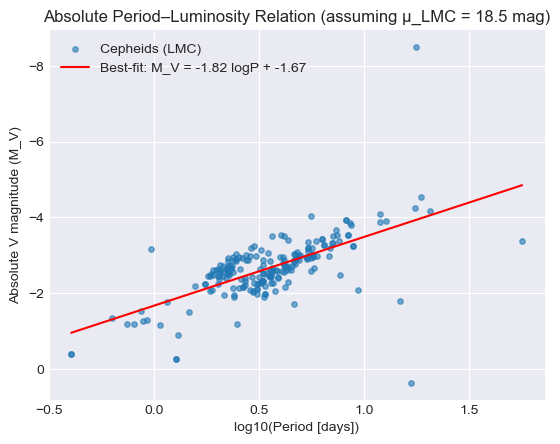

In [93]:
# ------------------------------------------------------------
# Extra: convert to absolute magnitudes and refit P–L relation
# (LMC only; uses an assumed distance modulus)
# ------------------------------------------------------------

# 1) Adopt a distance modulus for the LMC (common literature value)
# Distance modulus: mu = m - M  =>  M = m - mu
mu_LMC = 18.5   # mag (state this assumption in the write-up)

# 2) Compute absolute V magnitude for each Cepheid
# M_V = V_apparent - mu_LMC
M_V = clean["Vmag"].values - mu_LMC

# 3) Refit the same linear P–L form using absolute magnitudes
# M_V = a_abs * log10(P) + b_abs
logP = np.log10(clean["Per"].values)

def pl_model_abs(logP, a_abs, b_abs):
    """Absolute-magnitude P–L model in log-period space."""
    return a_abs * logP + b_abs

# Fit (least-squares)
popt_abs, pcov_abs = curve_fit(pl_model_abs, logP, M_V)
a_abs, b_abs = popt_abs

# Uncertainties from covariance matrix
a_abs_err, b_abs_err = np.sqrt(np.diag(pcov_abs))

# Report results
print("Best-fit absolute P–L relation (LMC, using mu_LMC = 18.5):")
print(f"M_V = ({a_abs:.3f} ± {a_abs_err:.3f}) * log10(P) + ({b_abs:.3f} ± {b_abs_err:.3f})")
print("Note: the zero-point depends directly on the assumed mu_LMC.")

# 4) Plot absolute-magnitude P–L relation
plt.figure()
plt.scatter(logP, M_V, s=15, alpha=0.6, label="Cepheids (LMC)")

x = np.linspace(logP.min(), logP.max(), 200)
plt.plot(x, pl_model_abs(x, a_abs, b_abs), color="red",
         label=f"Best-fit: M_V = {a_abs:.2f} logP + {b_abs:.2f}")

# Magnitude convention: invert y-axis so brighter is higher
plt.gca().invert_yaxis()

plt.xlabel("log10(Period [days])")
plt.ylabel("Absolute V magnitude (M_V)")
plt.title("Absolute Period–Luminosity Relation (assuming μ_LMC = 18.5 mag)")
plt.legend()
plt.grid(True)
plt.show()

## Classical Cepheids vs other types (I-band)

This section compares the Period–Luminosity (P–L) relation for **Classical Cepheids** (FU/FO/DM) versus **other OGLE Cepheid types** (FA/BR/etc.) using the **I-band apparent magnitude (Imag)**.

We fit separate linear P–L relations in log-period space for each group and plot them together to visualize how different Cepheid populations can follow different trends.

**Note:** Kyle primarily implemented this comparison + plotting section.

Number of Classical Cepheids: 195
Number of Other Cepheids: 9


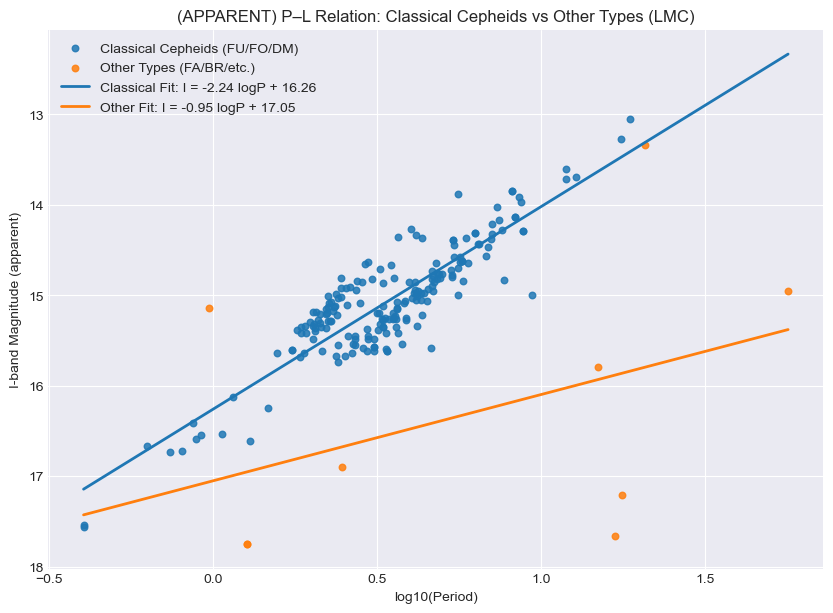

In [96]:
# -------------------------------
# Separate Classical vs Other Cepheids (LMC)
# Using I-band apparent magnitude (Imag)
# -------------------------------
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Classical Cepheid codes (Type I pulsation modes)
classical_labels = ["FU", "FO", "DM"]   # fundamental, first overtone, double-mode

# Subsets from the cleaned table
df_classical = clean[clean["Type"].isin(classical_labels)].copy()
df_other = clean[~clean["Type"].isin(classical_labels)].copy()

print("Number of Classical Cepheids:", len(df_classical))
print("Number of Other Cepheids:", len(df_other))

# Compute log10(period) for both subsets
df_classical["logP"] = np.log10(df_classical["Per"])
df_other["logP"] = np.log10(df_other["Per"])

# Linear P–L model in log-space: I = a * logP + b
def linear(x, a, b):
    return a * x + b

# Fit Classical
popt_classical, _ = curve_fit(linear, df_classical["logP"], df_classical["Imag"])
a_c, b_c = popt_classical

# Fit Other
popt_other, _ = curve_fit(linear, df_other["logP"], df_other["Imag"])
a_o, b_o = popt_other

# -------------------------------
# Plot Classical vs Other with Fits
# -------------------------------
plt.figure(figsize=(10, 7))

# Scatter points
plt.scatter(df_classical["logP"], df_classical["Imag"],
            s=22, alpha=0.85, label="Classical Cepheids (FU/FO/DM)")

plt.scatter(df_other["logP"], df_other["Imag"],
            s=22, alpha=0.85, label="Other Types (FA/BR/etc.)")

# Fit lines (use the same logP range from the FULL cleaned table)
xfit = np.linspace(np.log10(clean["Per"]).min(),
                   np.log10(clean["Per"]).max(), 200)

plt.plot(xfit, linear(xfit, a_c, b_c), linewidth=2,
         label=f"Classical Fit: I = {a_c:.2f} logP + {b_c:.2f}")

plt.plot(xfit, linear(xfit, a_o, b_o), linewidth=2,
         label=f"Other Fit: I = {a_o:.2f} logP + {b_o:.2f}")

# Magnitude convention: invert y-axis so brighter is higher
plt.gca().invert_yaxis()

plt.xlabel("log10(Period)")
plt.ylabel("I-band Magnitude (apparent)")
plt.title("(APPARENT) P–L Relation: Classical Cepheids vs Other Types (LMC)")
plt.legend()
plt.grid(True)
plt.show()

## P–L relation by pulsation mode (FU vs FO vs DM vs Others)

In this section, we split the cleaned OGLE Cepheid sample into pulsation modes (FU, FO, DM) and a catch-all “Other” group, then plot them together and fit separate P–L relations for the main modes.

**Note:** Abdirahman Abdullahi and Kyle Drees both worked on this section.

Counts:
FU (Fundamental): 118
FO (First Overtone): 69
DM (Double Mode): 8
Other Types: 9


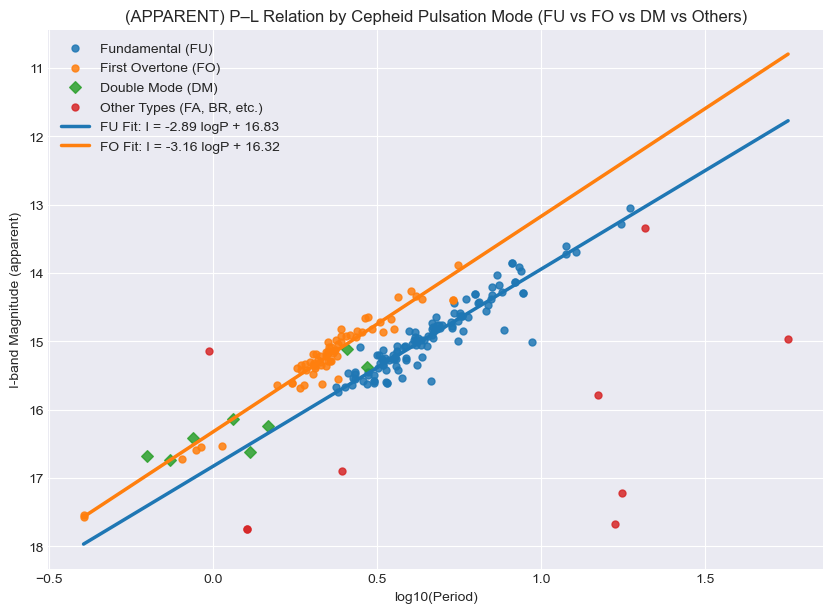

In [97]:
# ---------------------------------------------------------
# Separate FU vs FO vs DM vs Others and plot all together
# (LMC, using I-band apparent magnitude: Imag)
# ---------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Work from the cleaned table
df = clean.copy()

# Add log10(period)
df["logP"] = np.log10(df["Per"])

# --------------------------
# 1) Define categories
# --------------------------
fundamental = df[df["Type"] == "FU"]                 # Fundamental mode
first_overtone = df[df["Type"] == "FO"]              # First-overtone mode
double_mode = df[df["Type"] == "DM"]                 # Double-mode
other_types = df[~df["Type"].isin(["FU", "FO", "DM"])]  # Everything else (FA, BR, etc.)

print("Counts:")
print("FU (Fundamental):", len(fundamental))
print("FO (First Overtone):", len(first_overtone))
print("DM (Double Mode):", len(double_mode))
print("Other Types:", len(other_types))

# --------------------------
# 2) Linear model for P–L: I = a*logP + b
# --------------------------
def PL_model(x, a, b):
    return a * x + b

# Fit FU (usually enough points)
popt_FU, _ = curve_fit(PL_model, fundamental["logP"], fundamental["Imag"])
a_FU, b_FU = popt_FU

# Fit FO (usually enough points)
popt_FO, _ = curve_fit(PL_model, first_overtone["logP"], first_overtone["Imag"])
a_FO, b_FO = popt_FO

# Fit line range across full dataset
xfit = np.linspace(df["logP"].min(), df["logP"].max(), 300)

# --------------------------
# 3) Plot everything
# --------------------------
plt.figure(figsize=(10, 7))

# Scatter points (all groups)
plt.scatter(fundamental["logP"], fundamental["Imag"],
            s=25, alpha=0.85, label="Fundamental (FU)")

plt.scatter(first_overtone["logP"], first_overtone["Imag"],
            s=25, alpha=0.85, label="First Overtone (FO)")

plt.scatter(double_mode["logP"], double_mode["Imag"],
            s=35, alpha=0.85, marker="D", label="Double Mode (DM)")

plt.scatter(other_types["logP"], other_types["Imag"],
            s=25, alpha=0.85, label="Other Types (FA, BR, etc.)")

# Plot fit lines for FU & FO only
plt.plot(xfit, PL_model(xfit, a_FU, b_FU),
         linewidth=2.5, label=f"FU Fit: I = {a_FU:.2f} logP + {b_FU:.2f}")

plt.plot(xfit, PL_model(xfit, a_FO, b_FO),
         linewidth=2.5, label=f"FO Fit: I = {a_FO:.2f} logP + {b_FO:.2f}")

# Magnitude convention: invert y-axis so brighter is higher
plt.gca().invert_yaxis()

plt.xlabel("log10(Period)")
plt.ylabel("I-band Magnitude (apparent)")
plt.title("(APPARENT) P–L Relation by Cepheid Pulsation Mode (FU vs FO vs DM vs Others)")
plt.grid(True)
plt.legend()
plt.show()

## Results summary (what we found)

For the final report, we summarize each fitted Period–Luminosity relation (by galaxy and/or Cepheid type) with:

- slope **a ± σ(a)**
- intercept **b ± σ(b)**
- RMS residual scatter (mag)
- reduced **χ²** (note: if σ is estimated from the residual scatter, then χ²_red will tend to be ~1 by construction)

This makes the comparisons (e.g., LMC vs SMC, or FU vs FO) quantitative instead of visual-only.

**Note:** Subtracting a constant distance modulus (μ) shifts magnitudes by a constant, so it changes the **intercept** but does **not** change the **slope** or the **scatter**.

In [100]:
# ------------------------------------------------------------
# Results summary table (report-ready)
# ------------------------------------------------------------
# This table collects the key fit outputs we computed above.
# We recompute logP/residuals *inside this cell* so it can’t accidentally
# depend on whichever cell last overwrote variables like logP or V.

# --- Apparent V fit (LMC) ---
logP_app = np.log10(clean["Per"].values)
V_app = clean["Vmag"].values
resid_app = V_app - pl_model(logP_app, a, b)

sigma_app = np.std(resid_app, ddof=2)
dof_app = len(resid_app) - 2
chi2_red_app = np.sum((resid_app / sigma_app) ** 2) / dof_app

# --- Absolute V fit (LMC, assuming mu_LMC) ---
logP_abs = np.log10(clean["Per"].values)
M_V_abs = clean["Vmag"].values - mu_LMC
resid_abs = M_V_abs - pl_model_abs(logP_abs, a_abs, b_abs)

sigma_abs = np.std(resid_abs, ddof=2)
dof_abs = len(resid_abs) - 2
chi2_red_abs = np.sum((resid_abs / sigma_abs) ** 2) / dof_abs

results_df = pd.DataFrame([
    {
        "Case": "LMC apparent V fit",
        "Band": "Vmag",
        "N": len(V_app),
        "dof": dof_app,
        "a": a, "a_err": a_err,
        "b": b, "b_err": b_err,
        "RMS_resid_mag": sigma_app,
        "chi2_red": chi2_red_app
    },
    {
        "Case": f"LMC absolute V (assumed μ_LMC = {mu_LMC:.2f})",
        "Band": "M_V",
        "N": len(M_V_abs),
        "dof": dof_abs,
        "a": a_abs, "a_err": a_abs_err,
        "b": b_abs, "b_err": b_abs_err,
        "RMS_resid_mag": sigma_abs,
        "chi2_red": chi2_red_abs
    }
])

# Optional: nicer numeric formatting for display only
results_df_disp = results_df.copy()
for col in ["a", "a_err", "b", "b_err", "RMS_resid_mag", "chi2_red"]:
    results_df_disp[col] = results_df_disp[col].map(lambda x: f"{x:.4f}" if pd.notna(x) else "")

display(results_df_disp)

,Case,Band,N,dof,a,a_err,b,b_err,RMS_resid_mag,chi2_red
0,LMC apparent V fit,Vmag,204,202,-1.8156,0.1540,16.8339,0.0946,0.6382,1.0000
1,LMC absolute V (assumed μ_LMC = 18.50),M_V,204,202,-1.8156,0.1540,-1.6661,0.0946,0.6382,1.0000


## Conclusion

We recovered a clear Cepheid Period–Luminosity relation in the LMC: longer-period Cepheids are brighter (negative slope in magnitude space).  
The fitted relation provides a quantitative model with RMS scatter ~0.64 mag and reduced χ² ~1 (using the residual scatter as an empirical uncertainty).  
Converting to absolute magnitude using an assumed LMC distance modulus shifts the intercept but leaves the slope unchanged, as expected for a constant magnitude offset.  

These results demonstrate why Cepheids are powerful distance indicators and motivate comparing LMC vs SMC and different Cepheid subtypes when studying calibration systematics (e.g., metallicity effects) in the cosmic distance ladder.